In [1]:
from fundamental_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from photutils import CircularAperture
from photutils import aperture_photometry
import numpy as np

In [2]:
# The data
cube2 = 'FINAL_DATACUBE.fits'
hdu2 = F.open(cube2)
data = hdu2[1].data

In [3]:
#QSO redshift
zqso = 3.006
#Coordinate of centre of QSO (pix)
xqso = 225
yqso = 231


#Wavelength slice (in pixels) for PSF fitting/subtraction
wave_slice=120

#Central wavelength for PSF fitting (ang)
lamcen_psf =  6198.0

#PSF flux scaling box size (pix)
r_psf_scale = 6

#PSF subtraction box size (pix)
#Ideally 5x seeing
r_psf_sub = 15

#Velocity search window (wrt LyA; km/s)
vmin=-11000.0/1.5
vmax=5000.0

In [4]:
nw, nx, ny = data.shape
initial_lamb = hdu2[1].header['CRVAL3']

wavearr = np.arange(0.0, nw,1.0) * 1.25 + initial_lamb
ind1_lamcen_psf = int(1152 - wave_slice/2.0)
ind2_lamcen_psf = int(1152 + wave_slice/2.0)

print(wavearr[ind1_lamcen_psf], wavearr[ind2_lamcen_psf])

6115.4140625 6265.4140625


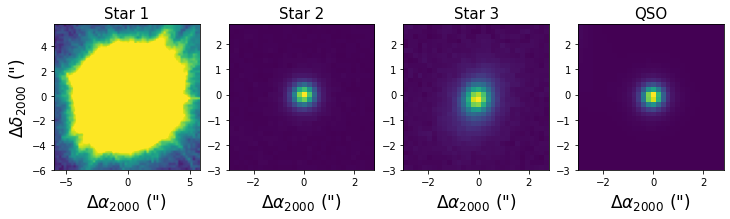

In [5]:
# Selecting the stars :D
x_s1 = 303
y_s1 = 303

x_s2 = 240
y_s2 = 188

x_s3 = 122
y_s3 = 323

star1_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s1-r_psf_sub*2):(y_s1+r_psf_sub*2), 
                (x_s1-r_psf_sub*2):(x_s1+r_psf_sub*2)].sum(axis=0)*1.25

star2_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s2-r_psf_sub):(y_s2+r_psf_sub), 
                (x_s2-r_psf_sub):(x_s2+r_psf_sub)].sum(axis=0)*1.25

star3_off = data[ind1_lamcen_psf:ind2_lamcen_psf, (y_s3-r_psf_sub):(y_s3+r_psf_sub), 
                (x_s3-r_psf_sub):(x_s3+r_psf_sub)].sum(axis=0)*1.25

qso_data = data[ind1_lamcen_psf:ind2_lamcen_psf, (xqso-r_psf_sub):(xqso+r_psf_sub), 
                (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25
                
x = np.arange(-15,15)*0.2
y = np.arange(-15,15)*0.2
x2 = np.arange(-30,30)*0.2
y2 = np.arange(-30,30)*0.2

plt.figure(figsize=(12,8))

plt.subplot(141)
plt.imshow(star1_off, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Star 1', fontsize=15)
plt.clim(-100,1000)

plt.subplot(142)
plt.imshow(star2_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.title('Star 2', fontsize=15)

plt.subplot(143)
plt.imshow(star3_off, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.title('Star 3', fontsize=15)

plt.subplot(144)
plt.imshow(qso_data, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.title('QSO', fontsize=15)

plt.show()

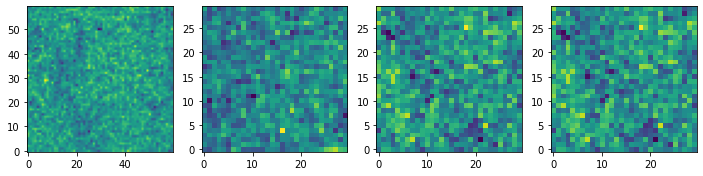

In [6]:
# Measurement of RMS sky noise near every star
sky1 = data[1:241, (y_s1-r_psf_sub*2-10):(y_s1+r_psf_sub*2-10), 
                (x_s1-r_psf_sub*2-100):(x_s1+r_psf_sub*2-100)].sum(axis=0)*1.25

sky2 = data[1:241, (y_s2-r_psf_sub-10):(y_s2+r_psf_sub+-10), 
                (x_s2-r_psf_sub-30):(x_s2+r_psf_sub-30)].sum(axis=0)*1.25

sky3 = data[1:241, (y_s3-r_psf_sub):(y_s3+r_psf_sub), 
                (x_s3-r_psf_sub+50):(x_s3+r_psf_sub+50)].sum(axis=0)*1.25

sky4 = data[1:241, (y_s3-r_psf_sub):(y_s3+r_psf_sub), 
                (x_s3-r_psf_sub+50):(x_s3+r_psf_sub+50)].sum(axis=0)*1.25       # QSO sky! 
 
RMS1 = np.sqrt(np.mean(sky1**2))
RMS2 = np.sqrt(np.mean(sky2**2))
RMS3 = np.sqrt(np.mean(sky3**2))
RMS4 = np.sqrt(np.mean(sky4**2))

plt.figure(figsize=(12,8))
plt.subplot(141)
plt.imshow(sky1, origin='lower')
plt.subplot(142)
plt.imshow(sky2, origin='lower')
plt.subplot(143)
plt.imshow(sky3, origin='lower')
plt.subplot(144)
plt.imshow(sky4, origin='lower')
plt.show()

In [7]:
# Fitting
X, Y = np.meshgrid(x,y)
X2, Y2 = np.meshgrid(x2,y2)
xdata = np.vstack((X.ravel(),Y.ravel()))
xdata2 = np.vstack((X2.ravel(),Y2.ravel()))

In [ ]:
f = lambda X, A, x_off, y_off,alpha_x, alpha_y, beta, off_set: moffat_integrated_func(X, A, x_off, y_off,alpha_x, alpha_y, beta,off_set, Ns=60)

param1, cov1 = curve_fit(f, xdata2, star1_off.ravel(), p0=p0)
print('Terminó el primer fit :D')

param2, cov2 = curve_fit(moffat_integrated_func, xdata, star2_off.ravel(), p0=p0)
print('Terminó el 2do fit :D')

param3, cov3 = curve_fit(moffat_integrated_func, xdata, star3_off.ravel(), p0=p0)
print('Terminó el tercer fit :D')

In [10]:
# Performing the fitting with the double component moffat PSF (fixed theta = pi/4).
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double = np.array([1e5, 1e5, 0. , 0., 1., 1., 1., 1., 0.1, 0.1, 0. ])
f = lambda X, A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set: double_moffat_integrated_func(X,  
                        A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, np.pi/4)

f2 = lambda X, A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set: double_moffat_integrated_func(X,  
                        A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set, np.pi/4, Ns=60)

param_s1, cov1 = curve_fit(f2, xdata2, star1_off.ravel(), p0=p0_double)
print('Terminó el 1er fit :D')

param_s2, cov2 = curve_fit(f, xdata, star2_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_s3, cov3 = curve_fit(f, xdata, star3_off.ravel(), p0=p0_double)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(f, xdata, qso_data.ravel(), p0=p0_double)
print('Terminó el fitteo')

c:\Users\urbin\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Terminó el 1er fit :D


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2400.

In [ ]:
# Performing the fitting with the double component moffat PSF (unfixed theta).
#A1, A2, x_off, y_off, alpha_x1, alpha_x2, alpha_y1, alpha_y2, beta1, beta2, off_set
p0_double_unfix = np.array([1e5, 1e5, 0. , 0., 1., 1., 1., 1., 0.1, 0.1, 0. , np.pi/4])

param_s1, cov1 = curve_fit(f, xdata, star1_off.ravel(), p0=p0_double_unfix)
print('Terminó el 1er fit :D')

param_s2, cov2 = curve_fit(f, xdata, star2_off.ravel(), p0=p0_double_unfix)
print('Terminó el 2do fit :D')

param_s3, cov3 = curve_fit(f, xdata, star3_off.ravel(), p0=p0_double_unfix)
print('Terminó el 2do fit :D')

param_QSO, cov_qso = curve_fit(f, xdata, qso_data.ravel(), p0=p0_double_unfix)
print('Terminó el fitteo')

In [8]:
# Previously found parameters (single moffat component): 
param1 = np.array([3.48502226e+08, -1.12297134e-01, -3.54697347e-02,  5.11584076e-01, 5.26599340e-01,  2.24434034e+00, 0.])
param2 = np.array([4.55544783e+05, -1.93387190e-02, -3.04570226e-02, -5.09779583e-01, 5.26201887e-01,  2.27797444e+00, 0.])
param3 = np.array([1.82898132e+05, -1.88034975e-01, -5.90714589e-02, -6.47519030e-01, 5.61422674e-01,  1.63870390e+00, 0.])

In [ ]:
# Params found for double component (fixed center and fixed rotation)
param_s1_rot = np.array([])

param_s2_rot = np.array([])

param_s3_rot = np.array([])

param_QSO_rot =  np.array([])

In [9]:
# PSF for single component moffat profile.
A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1 = param1
A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set1 = param2
A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set1 = param3

psf_s1 = moffat_integrated_func(xdata2, A1, x_off1, y_off1, alpha_x1, alpha_y1, beta1, off_set1 ,delta_x=0.2, delta_y=0.2, method='scipy', Ns=60)
psf_s2 = moffat_integrated_func(xdata, A2, x_off2, y_off2, alpha_x2, alpha_y2, beta2, off_set1 ,delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)
psf_s3 = moffat_integrated_func(xdata, A3, x_off3, y_off3, alpha_x3, alpha_y3, beta3, off_set1 ,delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1 = psf_s1.reshape(60,60)
psf_s2 = psf_s2.reshape(30,30)
psf_s3 = psf_s3.reshape(30,30)

In [ ]:
# Creating the PSF for the double component Moffat. (fixed rotation)
A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso, alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso = param_QSO_rot
A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1, beta1_s1, beta2_s1, off_set_s1 = param_s1_rot
A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2, beta1_s2, beta2_s2, off_set_s2 = param_s2_rot
A1_s3, A2_s3, x_off_s3, y_off_s3, alpha_x1_s3, alpha_x2_s3, alpha_y1_s3, alpha_y2_s3, beta1_s3, beta2_s3, off_set_s3 = param_s3_rot

psf_qso_rot = double_moffat_integrated_func(xdata, A1_qso, A2_qso, x_off_qso, y_off_qso, alpha_x1_qso, alpha_x2_qso, alpha_y1_qso,
                alpha_y2_qso, beta1_qso, beta2_qso, off_set_qso, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s1_rot = double_moffat_integrated_func(xdata, A1_s1, A2_s1, x_off_s1, y_off_s1, alpha_x1_s1, alpha_x2_s1, alpha_y1_s1, alpha_y2_s1,
                beta1_s1, beta2_s1, off_set_s1, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=60)

psf_s2_rot = double_moffat_integrated_func(xdata2, A1_s2, A2_s2, x_off_s2, y_off_s2, alpha_x1_s2, alpha_x2_s2, alpha_y1_s2, alpha_y2_s2,
                beta1_s2, beta2_s2, off_set_s2, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_s3_rot = double_moffat_integrated_func(xdata, A1_s3, A2_s3, x_off_s3, y_off_s3, alpha_x1_s3, alpha_x2_s3, alpha_y1_s3, alpha_y2_s3,
                beta1_s3, beta2_s3, off_set_s3, np.pi/4, delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

psf_qso_rot = psf_qso_rot.reshape(30,30)
psf_s1_rot = psf_s1_rot.reshape(60,60)
psf_s2_rot = psf_s2_rot.reshape(30,30)
psf_s3_rot = psf_s3_rot.reshape(30,30)

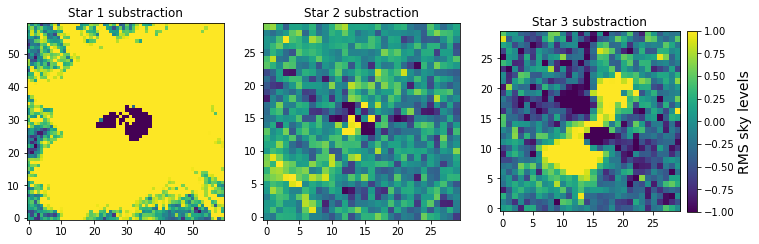

In [55]:
# Checking fits

diff_s1 = star1_off - psf_s1
diff_s2 = star2_off - psf_s2
diff_s3 = star3_off - psf_s3

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(diff_s1/RMS1, origin='lower')
plt.title('Star 1 substraction')
plt.clim(-1,1)

plt.subplot(132)
plt.imshow(diff_s2/RMS2, origin='lower')
plt.title('Star 2 substraction')
plt.clim(-1,1)

plt.subplot(133)
plt.imshow(diff_s3/RMS3, origin='lower')
plt.title('Star 3 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

In [ ]:
# Checking fits

diff_s1 = star1_off - psf_s1_rot
diff_s2 = star2_off - psf_s2_rot
diff_s3 = star3_off - psf_s3_rot
diff_qso = qso_data - psf_qso_rot

plt.figure(figsize=(12,8))
plt.subplot(141)
plt.imshow(diff_s1/RMS1, origin='lower')
plt.title('Star 1 substraction')
plt.clim(-1,1)

plt.subplot(142)
plt.imshow(diff_s2/RMS2, origin='lower')
plt.title('Star 2 substraction')
plt.clim(-1,1)

plt.subplot(143)
plt.imshow(diff_s3/RMS3, origin='lower')
plt.title('Star 3 substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

plt.subplot(143)
plt.imshow(diff_qso/RMS4, origin='lower')
plt.title('QSO substraction')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label('RMS sky levels', fontsize=14)
plt.clim(-1,1)

In [10]:
# Getting the centers of each PSF
psfcen_1 = np.argwhere(psf_s1 == np.max(psf_s1))[0]
psfcen_2 = np.argwhere(psf_s2 == np.max(psf_s2))[0]
psfcen_3 = np.argwhere(psf_s3 == np.max(psf_s3))[0]

#Get wavelenth of LyA at QSO redshift
wLyA = 1215.6701 * (1.0+zqso) 
#Create a search windown using minimum/maximm velocities; convert to wavelength
wmin = (1+vmin/2.998e5)*wLyA
wmax = (1+vmax/2.998e5)*wLyA

#Get indicies of this serach windown
windmin = 1
windmax = 161

#Get indicies in steps of wavelength slice
winds = np.arange(windmin, windmax, wave_slice)

#Create a fake, broadband PSF-subtracted image
sum_img1 = np.zeros((4*r_psf_sub, 4*r_psf_sub))
sum_img2 = np.zeros((2*r_psf_sub, 2*r_psf_sub))
sum_img3 = np.zeros((2*r_psf_sub, 2*r_psf_sub))

print(wmin, wmax)

4750.851185940005 4951.194807868179


In [12]:
sub_img1, img_1, norm1 = flux_scaling(psf_s1, y_s1, x_s1, psfcen_1, winds, wave_slice, data, 2*r_psf_sub, 2*r_psf_scale)
sub_img2, img_2, norm2 = flux_scaling(psf_s2, y_s2, x_s2, psfcen_2, winds, wave_slice, data, r_psf_sub, r_psf_scale)
sub_img3, img_3, norm3 = flux_scaling(psf_s3, y_s3, x_s3, psfcen_3, winds, wave_slice, data, r_psf_sub, r_psf_scale)

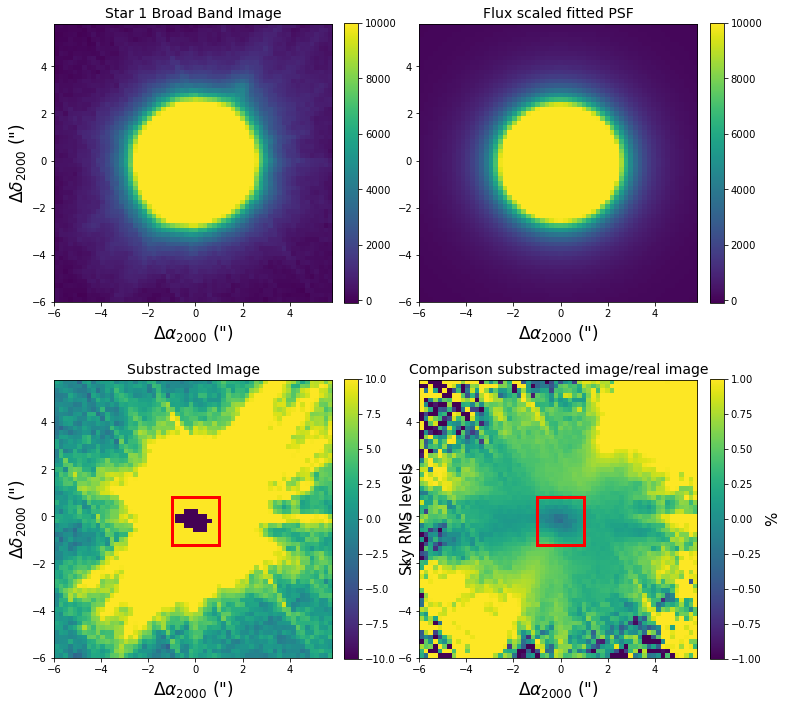

In [13]:
x2 = np.arange(-30,30)*0.2
y2 = np.arange(-30,30)*0.2

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_1, origin='lower',extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.colorbar(fraction=0.046, pad=0.04)
plt.clim(-100,10000)
plt.title('Star 1 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s1*norm1, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,10000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax3 =plt.subplot(223)
plt.imshow(sub_img1/RMS1, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax3.add_patch(Rectangle((x2[30]-1,x2[29]-1), 2, 2, edgecolor='red', facecolor='none', lw=3))
plt.clim(-10,10)
cb.set_label('Sky RMS levels', fontsize=15)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.title('Substracted Image', fontsize=14)

ax3=plt.subplot(224)
plt.imshow(sub_img1/img_1, origin='lower', extent=[x2[0],x2[-1],y2[0],y2[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax3.add_patch(Rectangle((x2[30]-1,x2[29]-1), 2, 2, edgecolor='red', facecolor='none', lw=3))
cb.set_label('%', fontsize=15)
plt.title('Comparison substracted image/real image', fontsize=14)
plt.show()

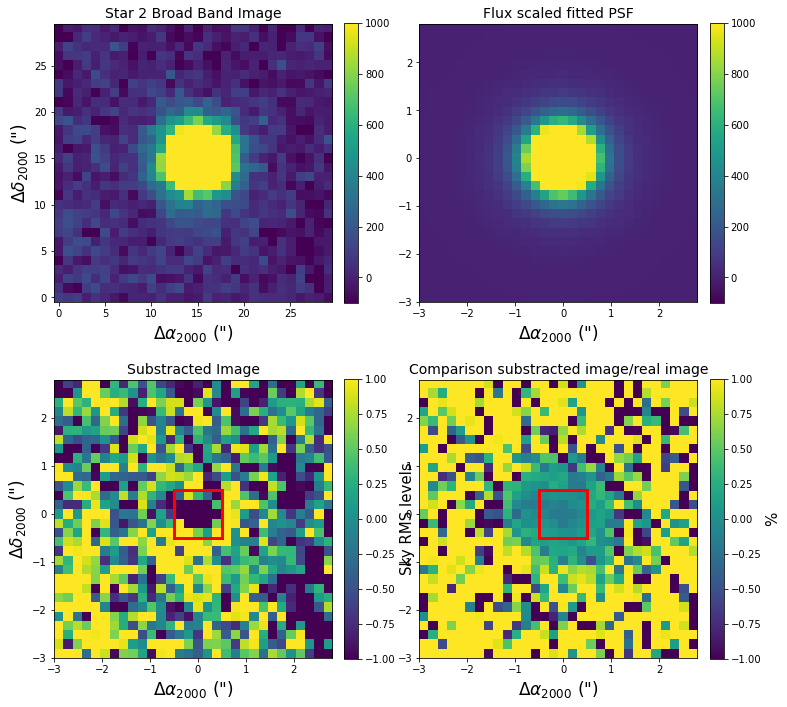

In [14]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_2, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 2 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s2*norm2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax= plt.subplot(223)
plt.imshow(sub_img2/RMS2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)


ax=plt.subplot(224)
plt.imshow(sub_img2/img_2, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[15]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)
plt.show()

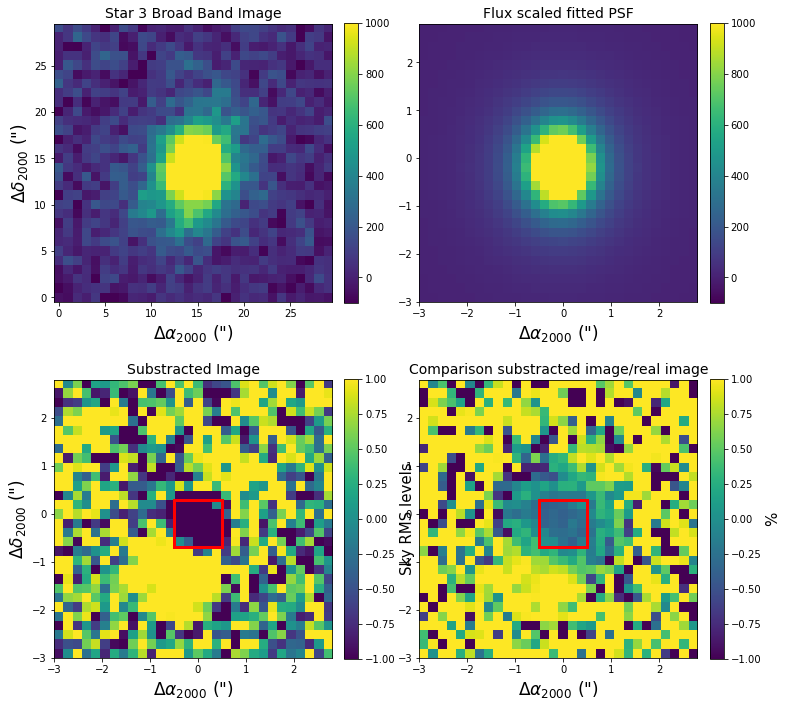

In [15]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_3, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Star 3 Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_s3*norm3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,1000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img3/RMS3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img3/img_3, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)
plt.show()

In [81]:
# Applying this to the cube
qso_data = data[ind1_lamcen_psf:ind2_lamcen_psf, (xqso-r_psf_sub):(xqso+r_psf_sub), 
                (yqso-r_psf_sub):(yqso+r_psf_sub)].sum(axis=0)*1.25

In [82]:
# Fitting
f = lambda X, A, x_off, y_off,alpha_x, alpha_y, beta: moffat_integrated_func(X, A, x_off, y_off,alpha_x, alpha_y, beta, 0)
guess = np.array([3.48502226e+08, -1.12297134e-01, -3.54697347e-02,  5.11584076e-01, 5.26599340e-01,  2.24434034e+00])  
param_QSO, cov_qso = curve_fit(f, xdata, qso_data.ravel(), p0=guess)
print('Terminó el fit :D')

Terminó el fit :D


In [83]:
print(param_QSO)

[ 5.97568233e+06 -8.21288585e-02 -3.63930883e-02  4.63887089e-01
  4.70755322e-01  2.09210693e+00]


In [84]:
A, x_off, y_off, _alpha_x, alpha_y, beta = param_QSO
psf_qso = moffat_integrated_func(xdata, A, x_off, y_off, _alpha_x, alpha_y, beta, 0 ,delta_x=0.2, delta_y=0.2, method='scipy', Ns=30)

In [85]:
# Reescaling
psf_qso = psf_qso.reshape(30,30)
psfcen_4 = np.argwhere(psf_qso == np.max(psf_qso))[0]
sum_img4 = np.zeros((2*r_psf_sub, 2*r_psf_sub))

sub_img4, img_4, norm4 = flux_scaling(psf_qso, xqso, yqso, psfcen_4, winds, wave_slice, data, r_psf_sub, r_psf_scale)

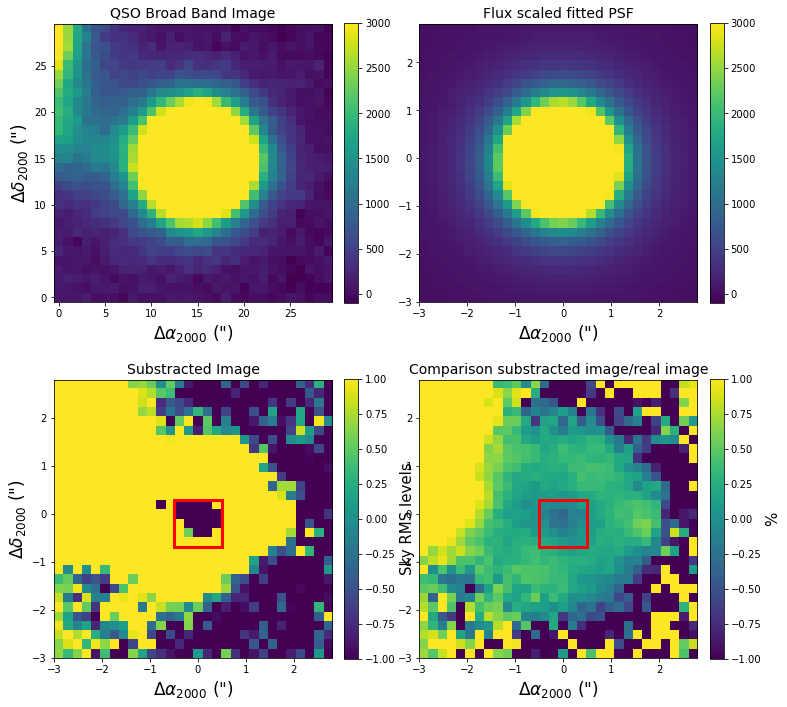

In [86]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.imshow(img_4, origin='lower')
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
plt.clim(-100,3000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('QSO Broad Band Image', fontsize=14)

plt.subplot(222)
plt.imshow(psf_qso*norm4, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-100,3000)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Flux scaled fitted PSF', fontsize=14)

ax2 = plt.subplot(223)
plt.imshow(sub_img4/RMS4, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label('Sky RMS levels', fontsize=15)
plt.title('Substracted Image', fontsize=14)
plt.clim(-1,1)

ax=plt.subplot(224)
plt.imshow(sub_img4/img_4, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
plt.clim(-1,1)
cb = plt.colorbar(fraction=0.046, pad=0.04)
ax.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.title('Comparison substracted image/real image', fontsize=14)
cb.set_label('%', fontsize=15)
plt.show()

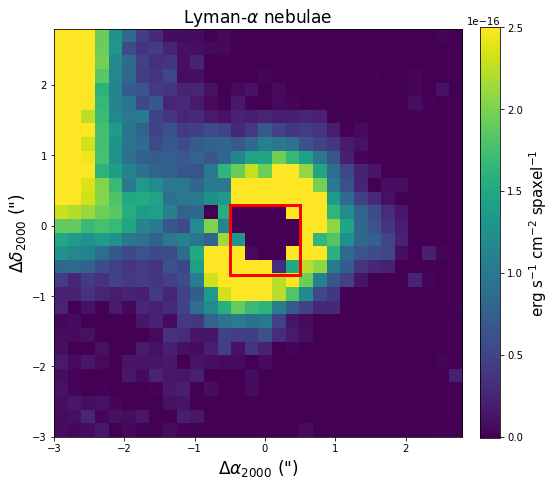

In [87]:
# Final image of the nebulae
scaling_factor = 10e-20
plt.figure(figsize=(8,8))
ax2 = plt.subplot(111)
plt.imshow(sub_img4*scaling_factor, origin='lower', extent=[x[0],x[-1],y[0],y[-1]])
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel(r'$\Delta \alpha_{2000}$ (")', fontsize=17)
ax2.add_patch(Rectangle((x[15]-0.5,x[14]-0.5), 1, 1, edgecolor='red', facecolor='none', lw=3))
plt.ylabel(r'$\Delta \delta_{2000}$ (")', fontsize=17)
cb.set_label(r'erg s$^{-1}$ cm$^{-2}$ spaxel$^{-1}$', fontsize=15)
plt.title(r'Lyman-$\alpha$ nebulae', fontsize=17)
plt.clim(-10*scaling_factor,2500*scaling_factor)

plt.show()